# Load Data

In [21]:
import numpy as np
import json
import csv

k = 4
X = np.genfromtxt('../data/impute_bvs_simplex_offset_X%d.csv' % k, delimiter=',', skip_header=False)[:(k-1), :]
Y = np.genfromtxt('../data/impute_bvs_simplex_offset_Y%d.csv' % k, delimiter=',', skip_header=False)
k = k-1
data = np.genfromtxt('../data/all_samples_filtered_train.csv', delimiter=',')
print(data)
m, n = data.shape

with open('../data/all_samples.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    key_to_index = dict([(h, i) for i, h in enumerate(header)])
    data_labels = [x for x in reader]
    
print(key_to_index.keys())
    
print(len(data_labels))

def get_label(i, key):
    return data_labels[i][key_to_index[key]]
        
print(get_label(0, 'ADIR:diagnosis'))
print(X.shape, Y.shape)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0. -1. ...,  0.  0.  0.]
 ..., 
 [-1.  0. -1. ..., -1. -1. -1.]
 [-1.  0.  0. ..., -1.  1.  1.]
 [-1.  0. -1. ...,  3.  3.  3.]]
dict_keys(['age', 'clinical_diagnosis', 'clinical_diagnosis_raw', 'cpea_adjusted_diagnosis', 'cpea_diagnosis', 'dataset', 'diagnosis', 'ethnicity', 'family', 'gender', 'identifier', 'interview_date', 'race', 'ADIR:A1', 'ADIR:A2', 'ADIR:A3', 'ADIR:A4', 'ADIR:abnormality_evident_before_3_years', 'ADIR:age', 'ADIR:B1', 'ADIR:B2', 'ADIR:B3', 'ADIR:B4', 'ADIR:C1', 'ADIR:C2', 'ADIR:C3', 'ADIR:C4', 'ADIR:communication', 'ADIR:diagnosis', 'ADIR:diagnosis_num_nulls', 'ADIR:interview_date', 'ADIR:Q02', 'ADIR:Q02a', 'ADIR:Q04', 'ADIR:Q04a', 'ADIR:Q05', 'ADIR:Q05a', 'ADIR:Q06', 'ADIR:Q06a', 'ADIR:Q07', 'ADIR:Q07a', 'ADIR:Q08', 'ADIR:Q08a', 'ADIR:Q09', 'ADIR:Q09a', 'ADIR:Q10', 'ADIR:Q10a', 'ADIR:Q11', 'ADIR:Q12', 'ADIR:Q12a', 'ADIR:Q13', 'ADIR:Q13a', 'ADIR:Q14', 'ADIR:Q14a', 'ADIR:Q15', 'ADIR:Q15a', 'A

In [2]:
print(X)

[[ 0.25011318  0.21920396  0.08217807 ...,  0.53137424  0.27129402
   0.12480244]
 [ 0.02455168  0.          0.34674106 ...,  0.20248442  0.61133754
   0.70406354]
 [ 0.72533513  0.78079604  0.57108087 ...,  0.26614134  0.11736843
   0.17113402]]


In [3]:
# Pull age and gender
with open('../data/all_samples.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    gender, age = [], []
    for line in reader:
        gender.append(None if line[7] == 'None' or line[7] == '' else line[7])
        if line[0] != 'None' and line[0] != '':
            age.append(int(line[0]))
        elif line[18] != 'None' and line[18] != '':
            age.append(int(line[18]))
        else:
            age.append(None)
print(age[:10])

[120, 120, 120, 120, 161, 117, 142, 119, 58, 47]


# Understand our validation data
Our validation data comes from ADIR and ADOS. Both give a diagnosis, and both also break down that diagnosis into three categories: communication, social interaction, and restricted and repeptitive behavior. These are the diagnostic criteria for ASD. Let's take a look at how these scores are distributed across our dataset.

## Diagnosis
This pie chart shows the diagnosis distribution across our dataset. The first diagnosis is ADIR and the second is ADOS. They have only 81% concordance.

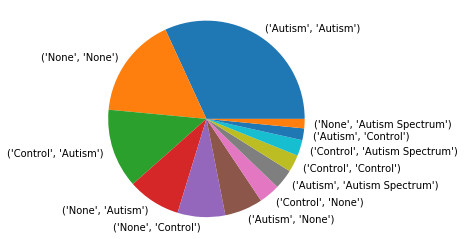

0.37922779448775396


In [5]:
from collections import Counter
import matplotlib.pyplot as plt


c = Counter([(get_label(i, 'ADIR:diagnosis'), get_label(i, 'ADOS:diagnosis')) for i in range(m)])
keys = [k for k, v in c.most_common()]
plt.pie([c[k] for k in keys], labels=keys)
plt.axis('equal')
plt.show()

print(sum([v for k, v in c.items() if (('Autism' in k[0] and 'Autism' in k[1]) or ('Control' in k[0] and 'Control' in k[1]))])/sum([v for v in c.values()]))


## Subscores - Communication, Social Interaction, and Restricted Repetitive Behavior
The communication scores are not correlated.

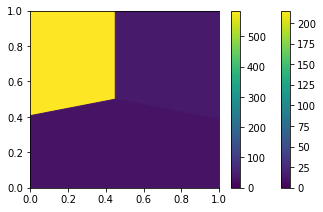

(-0.068750351541410001, 6.9641561738863722e-11)


In [37]:
adir_com = [get_label(i, 'ADIR:communication') for i in range(m)]
ados_com = [get_label(i, 'ADOS:communication') for i in range(m)]

adir_com = [-1 if x == 'None' else int(x) for x in adir_com]
ados_com = [-1 if x == 'None' else int(x) for x in ados_com]

# remove double zeros
com = zip(adir_com, ados_com)
com = [(a, b) for a, b in com if a>0 or b>0]

# plot
cay = plt.hexbin([a for a, b in com], [b for a, b in com], gridsize=10)
plt.colorbar(cay)
plt.show()

# pearson r
from scipy.stats.stats import pearsonr
print(pearsonr(np.asarray([a for a, b in com if a != -1 and b != -1], float), np.asarray([b for a, b in com if a != -1 and b != -1], float)))

The social interaction scores are correlated - pearson r is 0.43

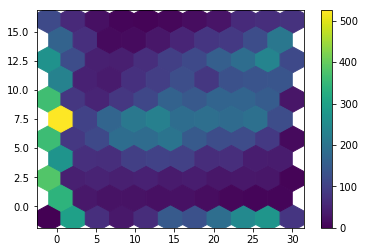

(0.27660900806389499, 9.7971268056901913e-158)


In [38]:
adir_si = [get_label(i, 'ADIR:social_interaction') for i in range(m)]
ados_si = [get_label(i, 'ADOS:social_interaction') for i in range(m)]

adir_si = [-1 if x == 'None' else int(x) for x in adir_si]
ados_si = [-1 if x == 'None' else int(x) for x in ados_si]

# remove double zeros
si = zip(adir_si, ados_si)
si = [(a, b) for a, b in si if a>0 or b>0]

# plot
cay = plt.hexbin([a for a, b in si], [b for a, b in si], gridsize=10)
plt.colorbar(cay)
plt.show()

# pearson r
print(pearsonr(np.asarray([a for a, b in si if a != -1 and b != -1], float), np.asarray([b for a, b in si if a != -1 and b != -1], float)))

The restricted, repetitive behavior scores are weakly correlated - pearson r is .11

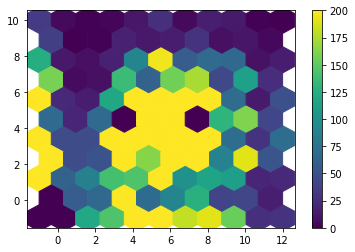

(0.12044648763071206, 3.7049586372061752e-30)


In [39]:
adir_rrb = [get_label(i, 'ADIR:restricted_repetitive_behavior') for i in range(m)]
ados_rrb = [get_label(i, 'ADOS:restricted_repetitive_behavior') for i in range(m)]

adir_rrb = [-1 if x == 'None' else int(x) for x in adir_rrb]
ados_rrb = [-1 if x == 'None' else int(x) for x in ados_rrb]

# remove double zeros
rrb = zip(adir_rrb, ados_rrb)
rrb = [(a, b) for a, b in rrb if a>0 or b>0]

# plot
cay = plt.hexbin([a for a, b in rrb], [b for a, b in rrb], gridsize=10, vmax=200)
plt.colorbar(cay)
plt.show()

# pearson r
print(pearsonr(np.asarray([a for a, b in rrb if a != -1 and b != -1], float), np.asarray([b for a, b in rrb if a != -1 and b != -1], float)))

In [40]:
print(np.sum(X, 1))

[ 5880.67402052  5271.1224612   5139.20351828]


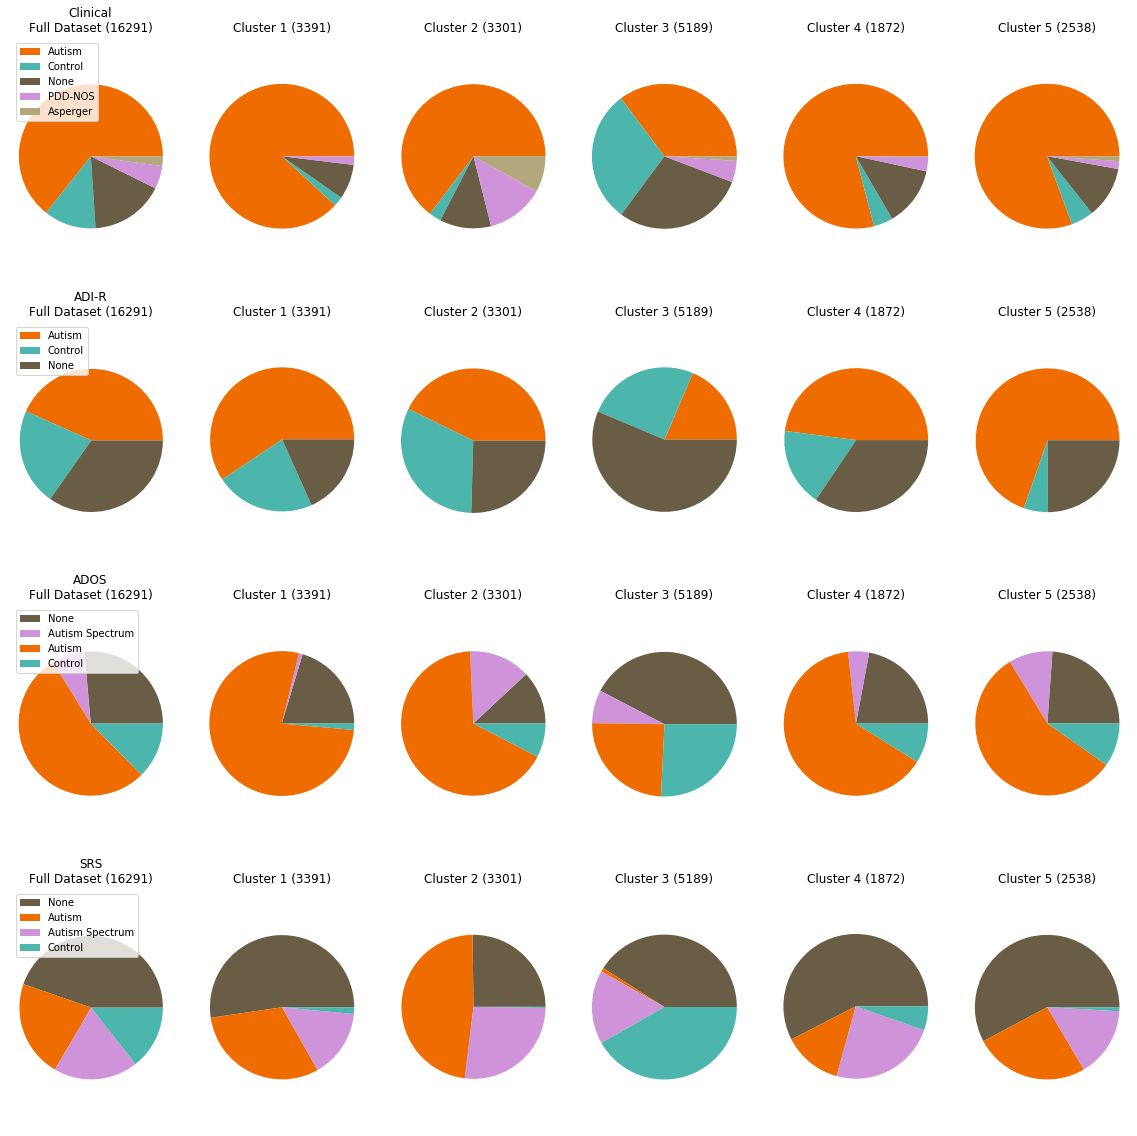

In [39]:
from collections import Counter
import math

plt.figure(figsize=(20, 20))


clin_c = Counter([get_label(index, 'clinical_diagnosis') for index in range(m)])
adir_c =  Counter([get_label(index, 'ADIR:diagnosis') for index in range(m)])
ados_c = Counter([get_label(index, 'ADOS:diagnosis') for index in range(m)])
srs_c = Counter([get_label(index, 'SRS:diagnosis') for index in range(m)])

clin_keys = clin_c.keys()
adir_keys = adir_c.keys()
ados_keys = ados_c.keys()
srs_keys = srs_c.keys()

colors = {'None': "#695d46", 'Control': "#4db6ac", 'Autism': "#ef6c00", 'PDD-NOS': "#ce93d8", 'Asperger': "#b3a77d", 'Autism Spectrum': "#ce93d8"}
plt.subplot(4, k+1, 1)
plt.pie([clin_c[k] for k in clin_keys], colors=[colors[k] for k in clin_keys])
plt.title('Clinical\nFull Dataset (%d)' % m)
plt.axis('equal')
plt.legend(loc="upper left", labels=clin_keys)

plt.subplot(4, k+1, k+2)
plt.pie([adir_c[k] for k in adir_keys], colors=[colors[k] for k in adir_keys])
plt.title('ADI-R\nFull Dataset (%d)' % m)
plt.axis('equal')
plt.legend(loc="upper left", labels=adir_keys)

plt.subplot(4, k+1, 2*k+3)
plt.pie([ados_c[k] for k in ados_keys], colors=[colors[k] for k in ados_keys])
plt.title('ADOS\nFull Dataset (%d)' % m)
plt.axis('equal')
plt.legend(loc="upper left", labels=ados_keys)
    
plt.subplot(4, k+1, 3*k+4)
plt.pie([srs_c[k] for k in srs_keys], colors=[colors[k] for k in srs_keys])
plt.title('SRS\nFull Dataset (%d)' % m)
plt.axis('equal')
plt.legend(loc="upper left", labels=srs_keys)

for i in range(k):
    #indexes = np.where(X[i, :]>.5)[0]
    indexes = np.where(np.argmax(X, axis=0)==i)[0]
    #indexes = np.where(clusters.predict(Z)==i)[0]
    #indexes = np.where(X[i, :]> 0)[0]
    #indexes = np.where(X[i, :]== 1)[0]
    c = Counter([get_label(index, 'clinical_diagnosis') for index in indexes])
    plt.subplot(4, k+1, i+2)
    plt.pie([c[k] for k in clin_keys], colors=[colors[k] for k in clin_keys])
    plt.title('Cluster %d (%d)' % (i+1, len(indexes)))
    plt.axis('equal')
    
    c = Counter([get_label(index, 'ADIR:diagnosis') for index in indexes])
    plt.subplot(4, k+1, i+(k+1)+2)
    plt.pie([c[k] for k in adir_keys], colors=[colors[k] for k in adir_keys])
    plt.title('Cluster %d (%d)' % (i+1, len(indexes)))
    plt.axis('equal')
    
    c = Counter([get_label(index, 'ADOS:diagnosis') for index in indexes])
    plt.subplot(4, k+1, i+(2*(k+1))+2)
    plt.pie([c[k] for k in ados_keys], colors=[colors[k] for k in ados_keys])
    plt.title('Cluster %d (%d)' % (i+1, len(indexes)))
    plt.axis('equal')
    
    c = Counter([get_label(index, 'SRS:diagnosis') for index in indexes])
    plt.subplot(4, k+1, i+(3*(k+1))+2)
    plt.pie([c[k] for k in srs_keys], colors=[colors[k] for k in srs_keys])
    plt.title('Cluster %d (%d)' % (i+1, len(indexes)))
    plt.axis('equal')
    

plt.show()
    

            

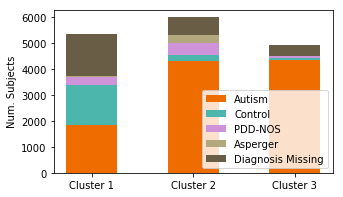

In [7]:
from collections import Counter
import math

plt.figure(figsize=(20, 20))


clin_c = Counter([get_label(index, 'clinical_diagnosis') for index in range(m)])
adir_c =  Counter([get_label(index, 'ADIR:diagnosis') for index in range(m)])
ados_c = Counter([get_label(index, 'ADOS:diagnosis') for index in range(m)])
srs_c = Counter([get_label(index, 'SRS:diagnosis') for index in range(m)])

colors = {'None': "#695d46", 'Control': "#4db6ac", 'Autism': "#ef6c00", 'PDD-NOS': "#ce93d8", 'Asperger': "#b3a77d", 'Autism Spectrum': "#ce93d8"}

ind = range(k)
width = 0.5

rautism, rcontrol, rpdd, rasp, rnone = [], [], [], [], []
for i in range(k):
    indexes = np.where(np.argmax(X, axis=0)==i)[0]
    c = Counter([get_label(index, 'clinical_diagnosis') for index in indexes])
    rautism.append(c['Autism'])
    rcontrol.append(c['Control'])
    rpdd.append(c['PDD-NOS'])
    rasp.append(c['Asperger'])
    rnone.append(c['None'])

plt.figure(figsize=(5, 3))
plt.bar(ind, rautism, width, color=colors['Autism'], label='Autism')
plt.bar(ind, rcontrol, width, bottom=rautism, color=colors['Control'], label='Control')
plt.bar(ind, rpdd, width, bottom=[sum(x) for x in zip(rautism, rcontrol)], color=colors['PDD-NOS'], label='PDD-NOS')
plt.bar(ind, rasp, width, bottom=[sum(x) for x in zip(rautism, rcontrol, rpdd)], color=colors['Asperger'], label='Asperger')
plt.bar(ind, rnone, width, bottom=[sum(x) for x in zip(rautism, rcontrol, rpdd, rasp)], color=colors['None'], label='Diagnosis Missing')
plt.ylabel('Num. Subjects')

plt.xticks(ind, ['Cluster %d' % (i+1) for i in range(k)])
plt.legend(loc='lower right')
plt.show()
          

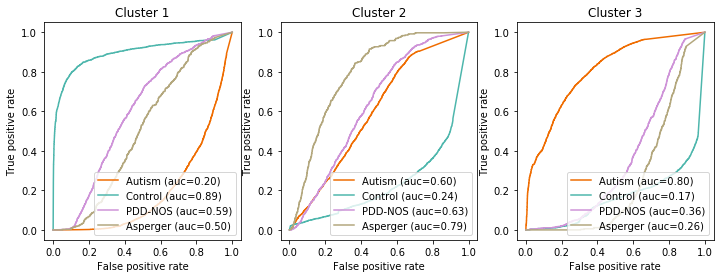

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score, roc_curve, auc
colors = {'None': "#695d46", 'Control': "#4db6ac", 'Autism': "#ef6c00", 'PDD-NOS': "#ce93d8", 'Asperger': "#b3a77d", 'Autism Spectrum': "#ce93d8"}

plt.figure(figsize=(12, 4))
for i in range(k):
    plt.subplot(1, k, (i+1))

    clin_d = [get_label(index, 'clinical_diagnosis') for index in range(m)]
    indices = [i for i, x in enumerate(clin_d) if x != 'None']

    fpr, tpr, _ = roc_curve([True if clin_d[i] == 'Autism' else False for i in indices], X[i, indices])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Autism (auc=%0.2f)' % roc_auc, color=colors['Autism'])
    
    fpr, tpr, _ = roc_curve([True if clin_d[i] == 'Control' else False for i in indices], X[i, indices])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Control (auc=%0.2f)' % roc_auc, color=colors['Control'])

    fpr, tpr, _ = roc_curve([True if clin_d[i] == 'PDD-NOS' else False for i in indices], X[i, indices])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='PDD-NOS (auc=%0.2f)' % roc_auc, color=colors['PDD-NOS'])

    fpr, tpr, _ = roc_curve([True if clin_d[i] == 'Asperger' else False for i in indices], X[i, indices])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Asperger (auc=%0.2f)' % roc_auc, color=colors['Asperger'])

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    
    plt.title('Cluster %d' % (i+1))
    plt.legend(loc='lower right')
plt.show()

(3, 16291)
16291
Counter({('Autism', 'Autism'): 10158, ('Control', 'Control'): 1296, ('PDD-NOS', 'Autism'): 820, ('Control', 'Autism'): 613, ('Asperger', 'Autism'): 348, ('Autism', 'Control'): 320, ('PDD-NOS', 'Control'): 21, ('Asperger', 'Control'): 6})


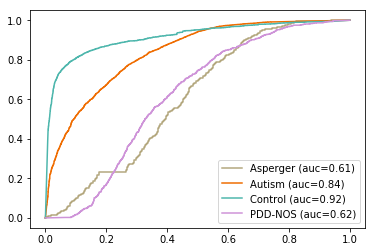

In [29]:
from sklearn.linear_model import LogisticRegression
from collections import Counter

Xdata = np.genfromtxt('../data/impute_bvs_simplex_offset_X%d.csv' % k, delimiter=',', skip_header=False)

indices = [i for i, x in enumerate(clin_d) if x != 'None']
print(Xdata.shape)
print(len(clin_d))
model = LogisticRegression(multi_class='ovr', solver='lbfgs', C=1000)
model.fit(Xdata.T[indices, :], [clin_d[i] for i in indices])
pred = model.predict_proba(Xdata.T[indices, :])

for i, c in enumerate(model.classes_):
    fpr, tpr, _ = roc_curve([clin_d[i] for i in indices], pred[:, i], pos_label=c)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s (auc=%0.2f)' % (c, roc_auc), color=colors[c])
    
print(Counter(zip([clin_d[i] for i in indices], model.predict(Xdata.T[indices, :]))))
plt.legend()
plt.show()


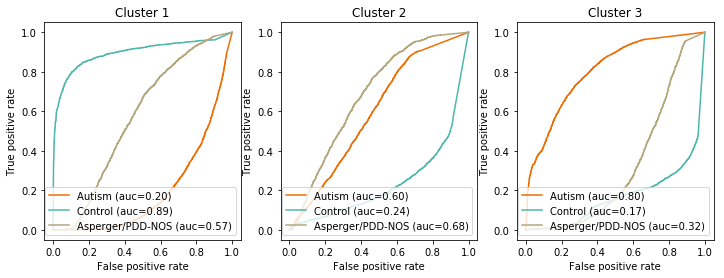

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score, roc_curve, auc

plt.figure(figsize=(12, 4))
for i in range(k):
    plt.subplot(1, k, (i+1))

    clin_d = [get_label(index, 'clinical_diagnosis') for index in range(m)]
    indices = [i for i, x in enumerate(clin_d) if x != 'None']

    fpr, tpr, _ = roc_curve([True if clin_d[i] == 'Autism' else False for i in indices], X[i, indices])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Autism (auc=%0.2f)' % roc_auc, color=colors['Autism'])
    
    fpr, tpr, _ = roc_curve([True if clin_d[i] == 'Control' else False for i in indices], X[i, indices])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Control (auc=%0.2f)' % roc_auc, color=colors['Control'])

    fpr, tpr, _ = roc_curve([True if clin_d[i] == 'Asperger' or clin_d[i] == 'PDD-NOS' else False for i in indices], X[i, indices])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Asperger/PDD-NOS (auc=%0.2f)' % roc_auc, color=colors['Asperger'])

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    
    plt.title('Cluster %d' % (i+1))
    plt.legend(loc='lower right')
plt.show()

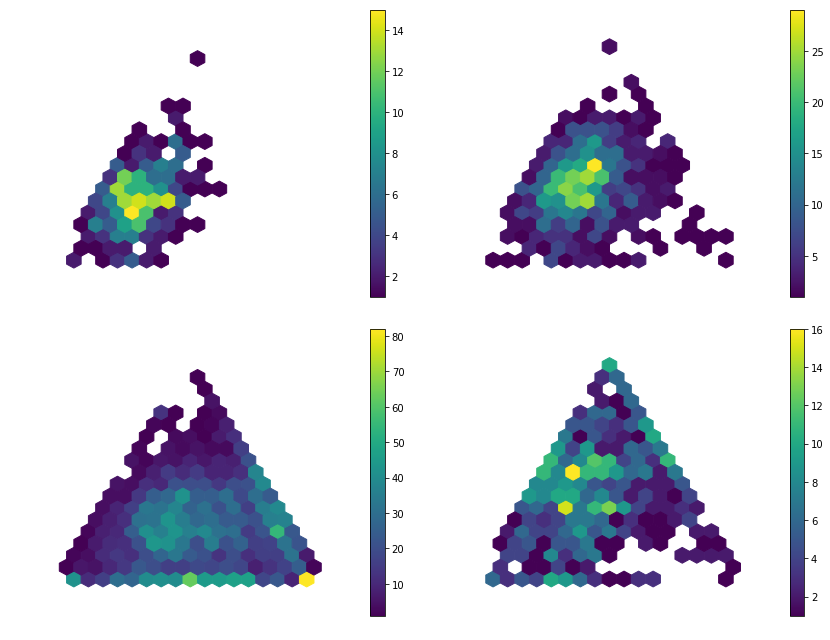

In [71]:
import matplotlib.pyplot as plt
import math

def get_clin(index):
    raw = get_label(index, 'clinical_diagnosis_raw')
    proc = get_label(index, 'clinical_diagnosis')
    
    if raw in {'NQA', 'BroadSpectrum'}:
        return ('AUTISM SPECTRUM MILDLY AFFECTED', proc)
    elif raw not in {'NQA', 'AUTISM SPECTRUM SEVERELY AFFECTED', 'AUTISM SPECTRUM MILDLY AFFECTED'}:
        return (proc, proc)
    else:
        return (raw, proc)

clin_d = [get_clin(index)[0] for index in range(m)]

plt.figure(figsize=(12, 9))

corners = [(0.5, math.sqrt(0.75)), (0, 0), (1, 0)]
for i, diag in enumerate(['Asperger', 'PDD-NOS', 'AUTISM SPECTRUM SEVERELY AFFECTED', 'AUTISM SPECTRUM MILDLY AFFECTED']):
#enumerate(['Control', 'Autism']):
#enumerate(['Asperger', 'PDD-NOS', 'NQA', 'BroadSpectrum', 'AUTISM SPECTRUM SEVERELY AFFECTED']):
    plt.subplot(2, 2, (i+1))
    diag_indices = [i for i in range(m) if clin_d[i] == diag]
    xs = corners[0][0]*X[0, diag_indices] + corners[1][0]*X[1, diag_indices] + corners[2][0]*X[2, diag_indices]
    ys = corners[0][1]*X[0, diag_indices] + corners[1][1]*X[1, diag_indices] + corners[2][1]*X[2, diag_indices]

    plt.axis('off')
    #plt.axis([0, 1, 0, math.sqrt(0.75)])
    cay = plt.hexbin(xs, ys, gridsize=20, extent=[-0.1, 1.1, -0.1, math.sqrt(0.75)+.1], mincnt=1)
    plt.colorbar(cay)
    #plt.title(diag)
plt.tight_layout()
plt.show()

In [179]:
from scipy.stats import hypergeom, norm
import math

print('Control, cluster 1', rcontrol[0]/sum(rcontrol))
print('PDD-NOS, cluster 2', rpdd[1]/sum(rpdd))
print('Asperger, cluster 2', rasp[1]/sum(rasp))
print('Autism, cluster 3', rautism[2]/sum(rautism))

Control, cluster 1 0.822943949711891
PDD-NOS, cluster 2 0.5671819262782402
Asperger, cluster 2 0.8502824858757062
Autism, cluster 3 0.41534644016033595


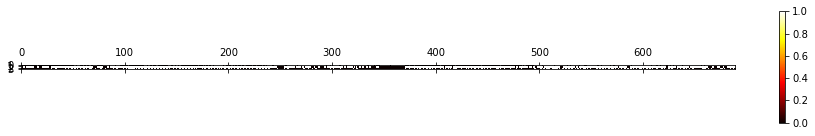

In [42]:
import matplotlib.pyplot as plt
cay = plt.matshow(Y>0, cmap='hot')
plt.colorbar(cay)
plt.show()

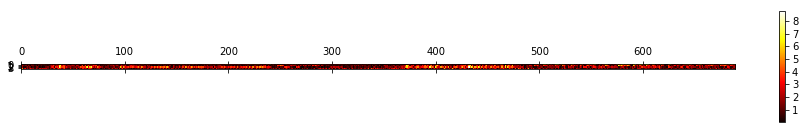

In [43]:
cay = plt.matshow(abs(Y), cmap='hot')
plt.colorbar(cay)
plt.show()

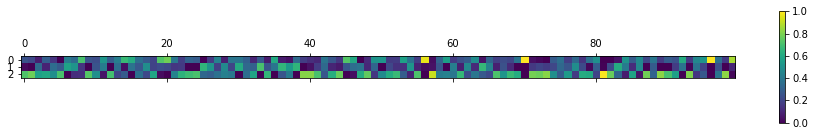

In [44]:
cay = plt.matshow(X[:, :100])
plt.colorbar(cay)
plt.show()

0.0140993964907
0


//anaconda/lib/python3.6/site-packages/scipy/spatial/distance.py:505: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - np.dot(u, v) / (norm(u) * norm(v))


1
2
3
4
5
6
7
8
9
10


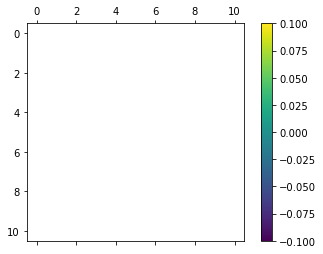

In [93]:
import random
from scipy import spatial

def missing_value_distance(a, b):
    indices = ~(np.isnan(a) | np.isnan(b))
    return spatial.distance.cosine(a, b)

print(missing_value_distance(np.array([1, 3, 4, 2]), np.array([1, 2, 4, 2])))
D = np.zeros((k, k))
for i in range(k):
    print(i)
    cluster_i_indices = list(np.where(np.argmax(X, axis=0)==i)[0])
    for j in range(k):
        if i < j:
            cluster_j_indices = list(np.where(np.argmax(X, axis=0)==j)[0])
            for isamp in random.sample(cluster_i_indices, 100):
                for jsamp in random.sample(cluster_j_indices, 100):
                    D[i, j] += missing_value_distance(data[isamp, :], data[jsamp, :])
            D[i, j] = D[i, j]/(len(cluster_i_indices)*len(cluster_j_indices))
            D[j, i] = D[i, j]
        elif i == j:
            for isamp in random.sample(cluster_i_indices, 100):
                for jsamp in random.sample(cluster_i_indices, 100):
                    D[i, i] += missing_value_distance(data[isamp, :], data[jsamp, :])
            D[i, i] = D[i, i]/(len(cluster_i_indices)*len(cluster_i_indices))
            
fig = plt.figure()
ax = fig.add_subplot(111)
cay = ax.matshow(D)
fig.colorbar(cay)

#ax.set_xticklabels(['']+['Cluster %d'%(i+1) for i in range(k)])
#ax.set_yticklabels(['']+['Cluster %d'%(i+1) for i in range(k)])
plt.show()

In [46]:
key_indexes = np.asarray([keys.index((get_label(i, 'ADIR:diagnosis'), get_label(i, 'ADOS:diagnosis'))) for i in range(m)])

plt.figure(figsize=(18, 15))
j = 0
for i, key in enumerate(keys):
    if 'None' not in key[0] and 'None' not in key[1]:
        plt.subplot(4, 3, j+1)
        j += 1
        plt.axis((0,1,0,1))
        cay = plt.hexbin(X[0, key_indexes==i], X[1, key_indexes==i], gridsize=10)
        plt.colorbar(cay)
        plt.title('ADIR:%s, ADOS:%s, %d' % (key[0] if key[0] != 'Control' else 'Not Autism', key[1] if key[1] != 'Control' else 'Not Autism', all_c[key]))
plt.show()

NameError: name 'all_c' is not defined

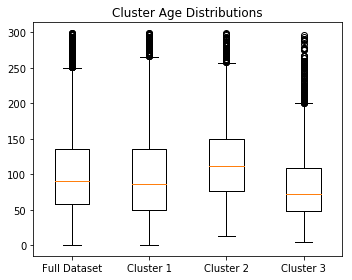

In [98]:
plt.figure(figsize=(5, 4))
age_boxplot_data = [[x for x in age if x is not None and x < 300]]
for i in range(k):
    plt.subplot(1, k+1, i+2)
    indexes = [j for j in range(m) if age[j] is not None and age[j] < 300 and X[i, j] == np.max(X[:, j])]
   # indexes = np.where(clusters.predict(Z)==i)[0]
    ages = [age[j] for j in indexes if age[j] is not None]
    #cay = plt.hexbin(X[i, indexes], ages, gridsize=10)
    #plt.colorbar(cay)
    #plt.title('Partial Cluster %d Membership vs Age' % (i+1))
    

    age_boxplot_data.append(ages)
    
plt.subplot(1, 1, 1)
#print([len(x) for x in boxplot_data])
plt.boxplot(age_boxplot_data, labels=["Full Dataset"] + ["Cluster %d" % (i+1) for i in range(k)])
plt.title('Cluster Age Distributions')
plt.tight_layout()
plt.show()

In [182]:
plt.figure(figsize=(12, 15))
for j, key in enumerate(['ADIR:communication', 'ADIR:social_interaction', 'ADIR:restricted_repetitive_behavior',
            'ADOS:communication', 'ADOS:social_interaction', 'ADOS:restricted_repetitive_behavior', 
            'SRS:social_awareness', 'SRS:social_cognition', 'SRS:social_communication', 'SRS:social_motivation', 'SRS:autistic_mannerisms']):
    #print(key)
    scores = [get_label(i, key) for i in range(m)]
    scores = np.asarray([-1 if x == 'None' else int(x) for x in scores])
    
    x_argmax = np.argmax(X, axis=0)
    
    boxplot_data = []#[[x for x in scores if x != -1]]
    for i in range(k):
        #plt.subplot(1, k+1, i+2)
        indexes = [s for s in range(m) if scores[s] != -1 and x_argmax[s] == i]
        #indexes = np.where(clusters.predict(Z)==i)[0]
        #cay = plt.hexbin(X[i, indexes], scores[indexes], gridsize=10)
        #plt.colorbar(cay)
        #plt.title('Partial Cluster %d Membership vs \n%s Score' % (i+1, key))
        
        boxplot_data.append([scores[j] for j in indexes])
    
    plt.subplot(4, 3, j+1)
    #print([len(x) for x in boxplot_data])
    plt.boxplot(boxplot_data, labels=["Cluster %d" % (i+1) for i in range(k)])
    plt.title(key.replace('_', ' '))
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [183]:
plt.figure(figsize=(15, 4))
key = 'ADIR:social_interaction'
#key = 'ADIR:restricted_repetitive_behavior'
scores = [get_label(i, key) for i in range(m)]
scores = np.asarray([-1 if x == 'None' else int(x) for x in scores])
    
x_argmax = np.argmax(X, axis=0)
print(x_argmax)
   
boxplot_indices = [[i for i, x in enumerate(scores) if x != -1]]
for i in range(k):
    #plt.subplot(1, k+1, i+2)
    indexes = [s for s in range(m) if scores[s] != -1 and x_argmax[s] == i]
    #indexes = np.where(clusters.predict(Z)==i)[0]
    #cay = plt.hexbin(X[i, indexes], scores[indexes], gridsize=10)
    #plt.colorbar(cay)
    #plt.title('Partial Cluster %d Membership vs \n%s Score' % (i+1, key))
        
    boxplot_indices.append(indexes)
    
boxplot_data = []
for indices in boxplot_indices:
    boxplot_data.append([scores[i] for i in indices])

plt.subplot(1, 4, 1)
plt.boxplot(boxplot_data, labels=["Full\nDataset"] + ["Cluster %d" % (i+1) for i in range(k)])
plt.title(key.replace('_', ' '))

for i in range(k):
    #plt.subplot(1, k+1, i+2)
    indexes = [s for s in range(m) if scores[s] != -1 and X[i, s] > 0 and X[i, s] < 1]
    #cay = plt.hexbin(X[i, indexes], scores[indexes], gridsize=10)
    #plt.colorbar(cay)
   
    plt.subplot(1, 4, i+2)
    cay = plt.hexbin(X[i, indexes], scores[indexes], gridsize=15)
    plt.colorbar(cay)
    plt.title('Partial Cluster %d Membership vs \n%s Score' % (i+1, key))

plt.tight_layout()
plt.show()

[2 2 2 ..., 0 1 1]


KeyboardInterrupt: 

In [306]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=4)
model.fit(X)
print(model.labels_)

[1 2 2 ..., 3 0 3]


[ True  True  True ...,  True  True  True]


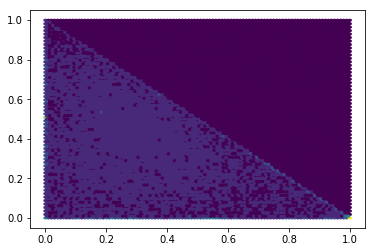

In [68]:
from collections import Counter
import matplotlib.cm as cm

#autism_indices
#plt.scatter(X[0, :], X[1, :], marker='.', s=30, alpha=0.7)

indices = ~np.any(X==1, axis=0)
print(indices)
plt.hexbin(X[0, indices], X[1, indices], bins=10)
#plt.scatter(X[cluster_labels == 0, 0], X[cluster_labels == 0, 1], marker='.', s=30, lw=0, alpha=0.7,
#                c="red", edgecolor='k')
plt.show()

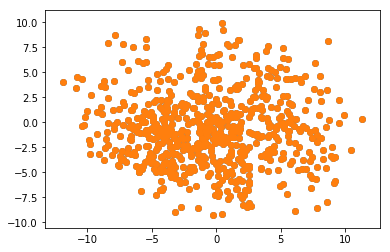

In [77]:
plt.scatter(Y[0, :], Y[1, :])
plt.show()